In [1]:
import jax
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel.experimental.optim as opt
import liesel.model as lsl

We take a super simple Liesel model here

In [2]:
xval = 2.0 * jax.random.normal(jax.random.key(42), (10_000,)) + 3.0

Next, we create a train/validation/test split of the data.

In [3]:
split = opt.Split(
    position_keys=["x"],
    n=xval.size,  # full size of the axis along which we split
    n_validate=200,
    n_train=1000,
    n_test=0,  # I don't use any test data in this example
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)

# By default, opt.Split does not randomize the order of the data.
# That can be done manually.
split.indices = split.permute_indices(jax.random.key(4))

# Finally, we apply the split to the position
position = {"x": xval}
data = split.split_position(position)

Next, we prepare batching.

In [4]:
bi = opt.Batches(
    position_keys=["x"],
    n=data.n_train,  # full size of the training data set.
    batch_size=256,
    shuffle=True,  # can be set to turn off shuffling in Batches.permute_indices
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)
initial_batch = bi.get_batched_position(data.train, batch_index=0)

We initialize the liesel model with the first batch.

In [5]:
m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
s.transform(tfb.Exp())
x = lsl.Var.new_obs(
    initial_batch["x"],
    distribution=lsl.Dist(tfd.Normal, loc=m, scale=s),
    name="x",
)
p = lsl.Model([x])

Next, we initialize our loss object.

In [6]:
loss = opt.NegLogProbLoss(
    model=p,
    split=data,
    # considers only log likelihood in validation loss for early stopping
    # to measure predictive likelihood
    # can be changed to "log_prob", if you explicitly want to also consider the prior
    validation_strategy="log_lik",
)

Next, we initialize the optimizer.

In [7]:
parameters = list(p.parameters)
optim = opt.Optimizer(parameters, optimizer=optax.adam(learning_rate=1e-2))

Next, we initialize the engine.

In [8]:
engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=1000, patience=50, atol=0.0, rtol=1e-4),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

Finally, we run the optimization.

In [9]:
result = engine.fit()

Training loss: 2111.799, Validation loss: 2125.135:  33%|███▎      | 330/1000 [00:00<00:00, 882.72it/s] 


Now we can inspect the loss and parameter history.

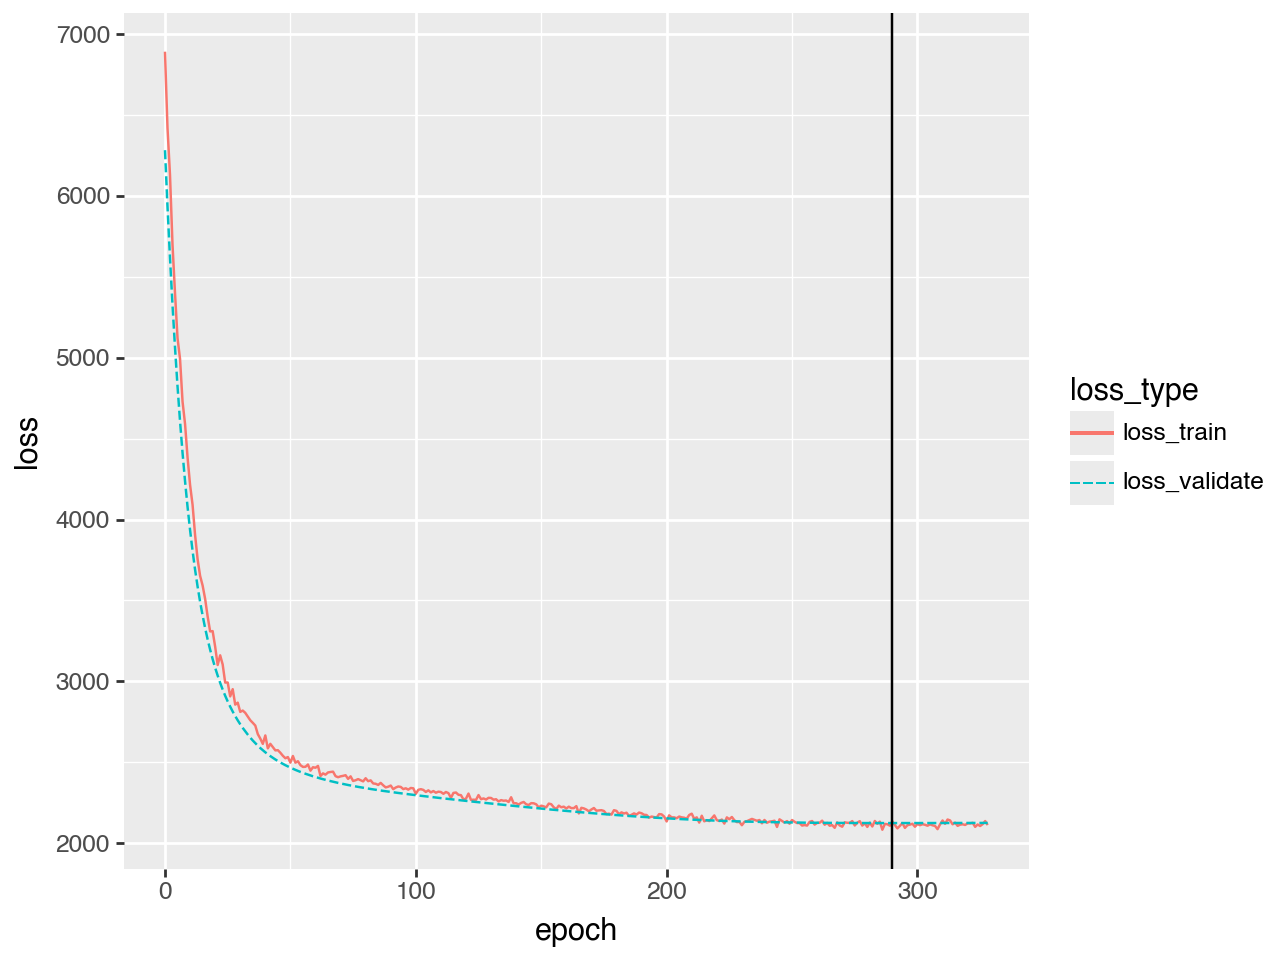

In [10]:
result.plot_loss()

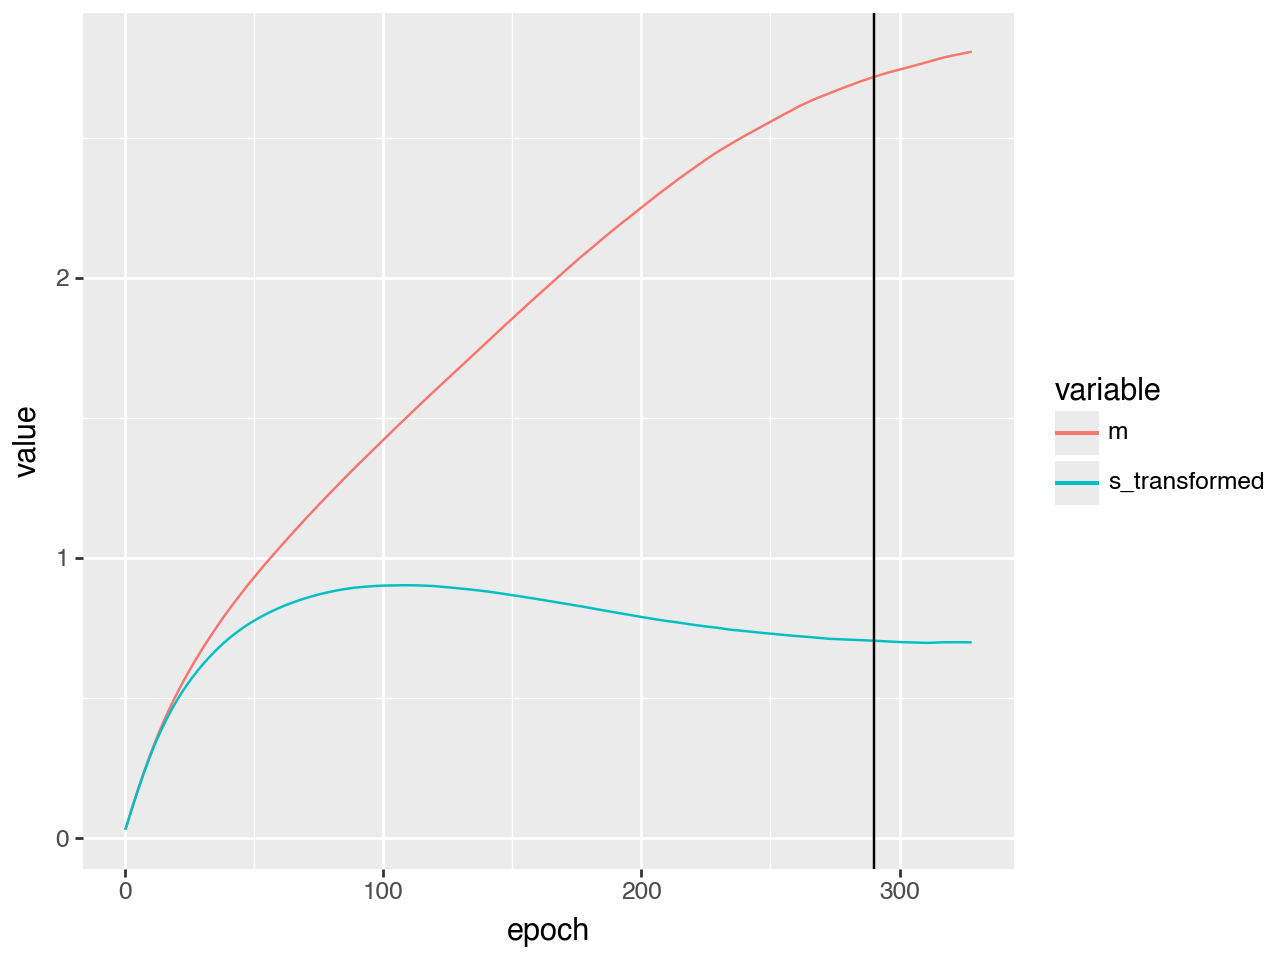

In [11]:
result.plot_param_history()

Plot history on the untransformed level

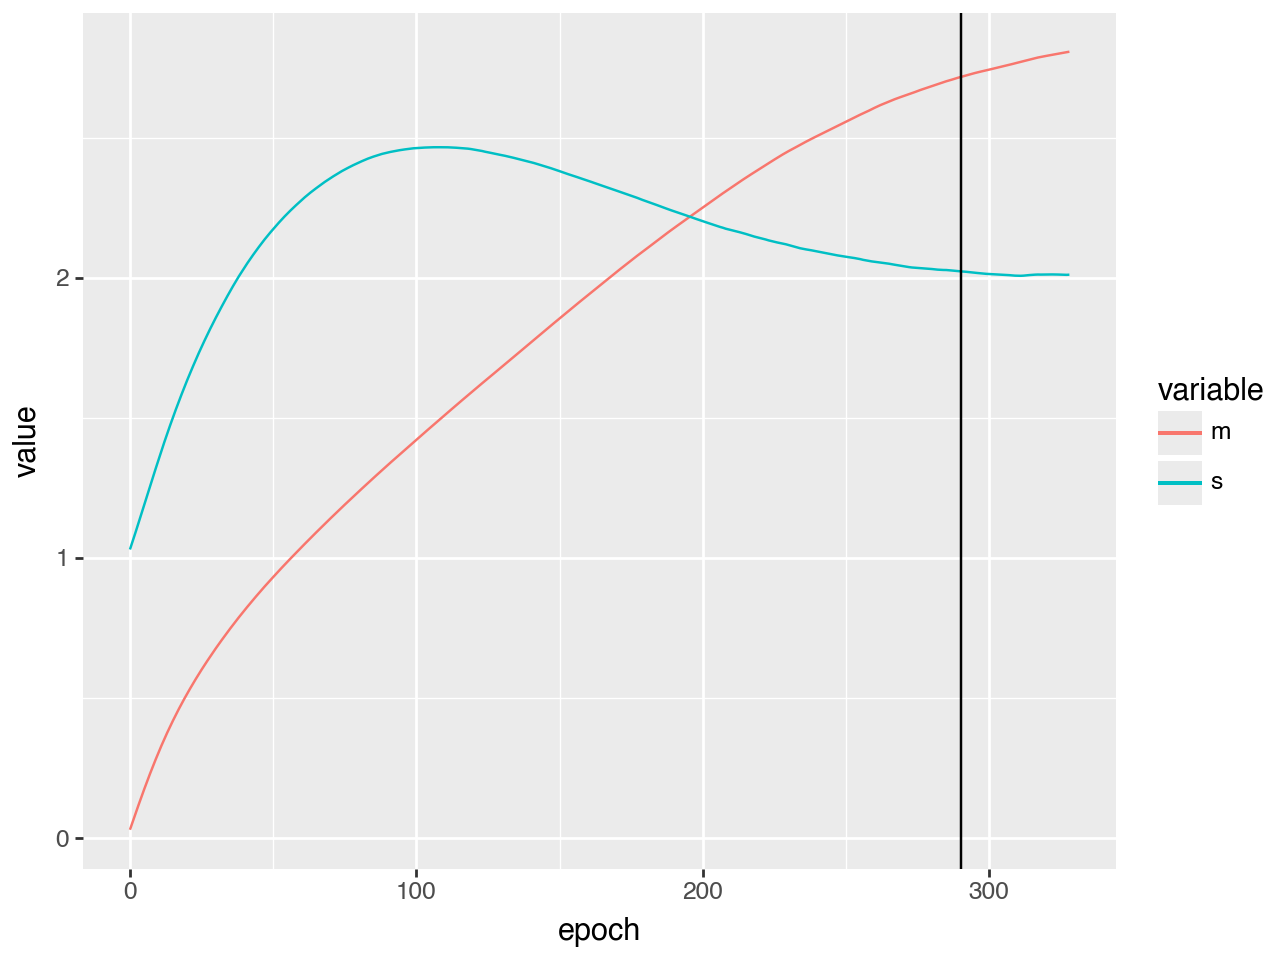

In [12]:
param_history = p.predict(result.history.position, ["m", "s"])
result.plot_param_history(param_history)

## Variations

### Blocked optimizers

In [13]:
opt1 = opt.Optimizer(["m"], optimizer=optax.adam(learning_rate=1e-2))
opt2 = opt.Optimizer(["s_transformed"], optimizer=optax.adam(learning_rate=1e-5))
optimizers = [opt1, opt2]

### Using L-BFGS

L-BFGS is a quasi-Newton method. It tries to approximate the curvature (inverse Hessian) of the objective. To build a good curvature estimate, it assumes you’re giving it gradients of the same underlying function each step. Therefore, you usually do not want to use batching when optimizing with L-BFGS.

In [14]:
split = opt.Split(["x"], xval.size, n_validate=10)
data = split.split_position({"x": xval})
bi = opt.Batches(
    position_keys=[],
    n=data.n_train,  # full size of the training data set.
    batch_size=None,
)

m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
s.transform(tfb.Exp())
x = lsl.Var.new_obs(
    data.train["x"],
    distribution=lsl.Dist(tfd.Normal, loc=m, scale=s),
    name="x",
)
p = lsl.Model([x])

parameters = list(p.parameters)
optim = opt.LBFGS(parameters)

loss = opt.NegLogProbLoss(
    model=p,
    split=data,
    # considers only log likelihood in validation loss for early stopping
    # to measure predictive likelihood
    # can be changed to "log_prob", if you explicitly want to also consider the prior
    validation_strategy="log_lik",
)

engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=1000, patience=50, atol=0.0, rtol=1e-4),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

In [15]:
result = engine.fit()

Training loss: 21011.221, Validation loss: 22263.451:   6%|▌         | 58/1000 [00:00<00:11, 83.39it/s]


L-BFGS converges very quickly, so the high patience that we used here is a bit over-the-top.

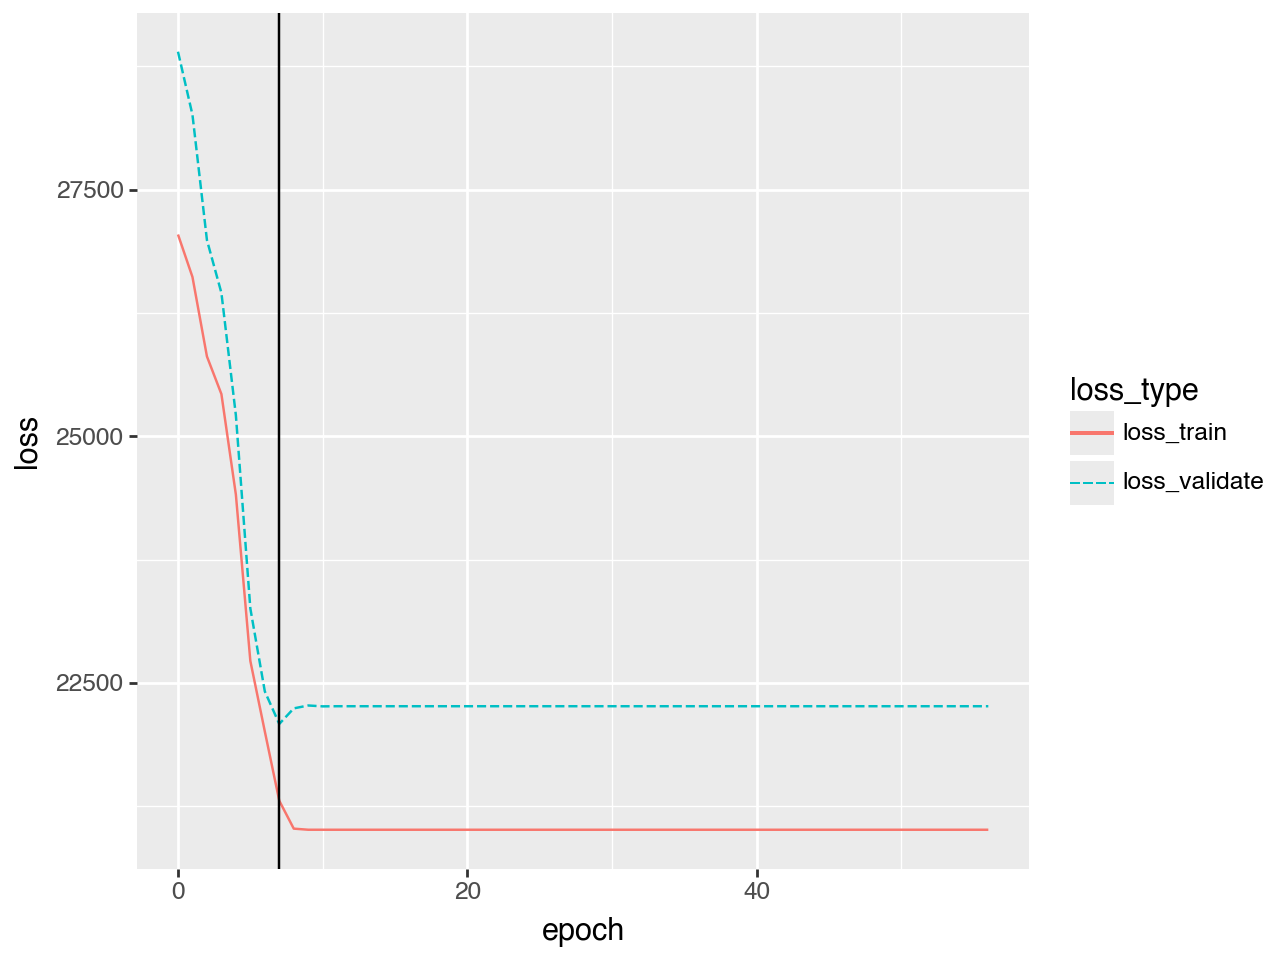

In [16]:
result.plot_loss()

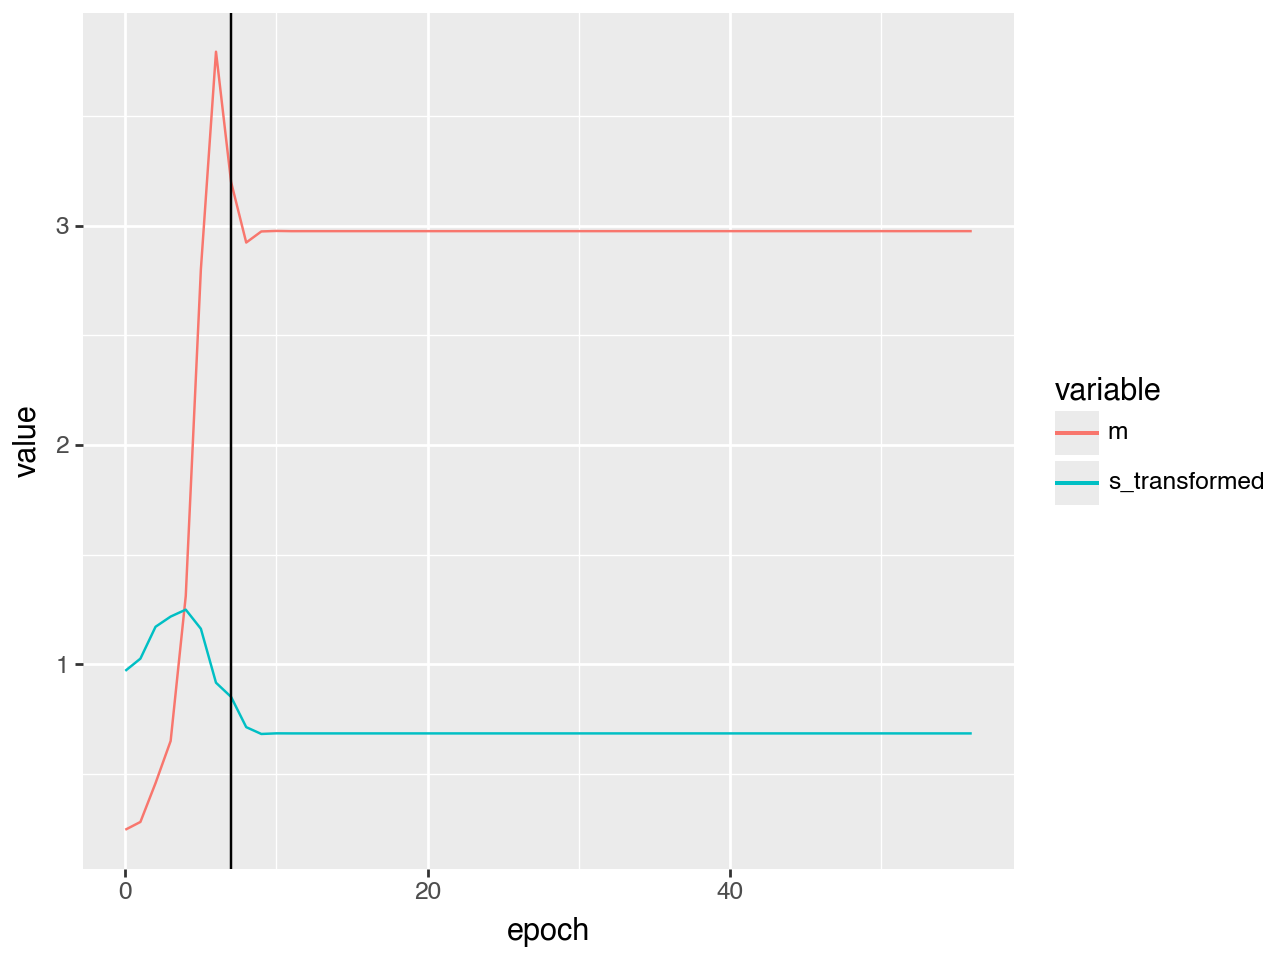

In [17]:
result.plot_param_history()